In [9]:
#basics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#text process
import nltk
import unidecode
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Processamento dos dados

Como existem dados textuais podemos usar as funções já utilizadas no trabalho anterior




In [10]:
with open('./data/dataset.csv', encoding="utf8") as file:
    df = pd.read_csv(file)
    
df.head()

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,0
1,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
2,2,NaN,NaN,"Heard about #earthquake is different cities, s...",0
3,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",0
4,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1


## Separação treino e teste

In [11]:
from sklearn.model_selection import train_test_split

df_train_raw, df_test_raw = train_test_split(df, test_size=0.2)

In [12]:
print(df_train_raw.shape)
df_train_raw.head()

(8700, 5)


,id,keyword,location,text,target
5425,5425,first%20responders,NaN,Carmike Cinemas on Antioch Shooting: 'We Are G...,1
6562,6562,injury,NaN,nflweek1picks: Michael Floyd's hand injury sho...,0
9148,9148,suicide%20bomber,NaN,#ISIS claims responsibility for Saudi suicide ...,1
6332,6332,hostage,NaN,@gideonstrumpet Have you been held hostage?,0
3631,3631,desolation,Prehistoric Earth,I REALLY liked the first Hobbit movie. I saw i...,0


In [13]:
print(df_test_raw.shape)
df_test_raw.head()

(2176, 5)


,id,keyword,location,text,target
8619,8619,seismic,NaN,#Sismo DETECTADO #JapÌ_n [Report 6] 01:02:42 O...,0
8801,8801,sirens,"Nomad, USA",Fuck Sleeping With Sirens.,0
8951,8951,storm,NaN,Well this storm hit out of no where! ??,0
3791,3791,destruction,NaN,New RAN report from the frontlines of human ri...,0
7461,7461,obliteration,"kissimmee,fl.",Why did God order obliteration of ancient Cana...,0


## Limpeza dos textos dos tweets

Um coisa interessante de se pensar é que os dados textuais se dão através de textos escritos por pessoas em sua rede social tweeter e podem existir erros de digitação assim é importante tentar corrigir as palavras mal escritas. Para isso podemos usar a biblioteca spell checker.

In [14]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vitor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vitor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vitor\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\vitor\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Reutilizando funções do trabalho prático

In [16]:
def remove_specials(tokens):
    return [unidecode.unidecode(word) for word in tokens]

def remove_punctuation(tokens):
    table = str.maketrans("","",string.punctuation)
    return [w.translate(table) for w in tokens]

def array_lower(tokens):
    return [w.lower() for w in tokens]

def remove_no_words(tokens):
    return [word for word in tokens if word.isalpha()]

def remove_stop_words(tokens):
    stop_words = set(stopwords.words('english'))
    return [w for w in tokens if not w in stop_words]


def text_cleaner(string):
   
    # Dividindo texto em tokens
    string = word_tokenize(string)
    #df_text_column = df_text_column.apply(word_tokenize)
    
    # Convertendo texto para minusculo
    string = array_lower(string)
    #df_text_column = df_text_column.apply(array_lower)

    # Removendo pontuação
    string = remove_punctuation(string)
    #df_text_column = df_text_column.apply(remove_punctuation)
    
    # Removendo caracteres especiais
    string = remove_specials(string)
    #df_text_column = df_text_column.apply(remove_specials)

    # Removendo tokens que não sao palavras
    string = remove_no_words(string)
    #df_text_column = df_text_column.apply(remove_no_words)

    # Removendo tokens que são stop words
    string = remove_stop_words(string)
    #df_text_column = df_text_column.apply(remove_stop_words)
    
    return string

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

#do_nothing = lambda x: x
N_COMPONENTS = 1000 #Vimos com o PCA diminuindo metade das featues tinha uma variancia explicada alta

wordnet_lemmatizer = WordNetLemmatizer()
lemmazation = lambda words: [wordnet_lemmatizer.lemmatize(tk) for tk in words]


tfidf = TfidfVectorizer(tokenizer = lemmazation,lowercase=False, preprocessor=text_cleaner, ngram_range=(1, 2),min_df=10,max_df=0.95)

text_process_pipe = Pipeline([
                             ("tfidf",tfidf),
                             ("pca", TruncatedSVD(n_components=N_COMPONENTS))
                             ])


In [19]:
X_train = text_process_pipe.fit_transform(df_train_raw['text'])
y_train = df_train_raw['target']

In [21]:
X_test = text_process_pipe.transform(df_test_raw['text'])
y_test = df_test_raw['target']

In [22]:
print(f"Total variance explained: {text_process_pipe['pca'].explained_variance_ratio_.sum()*100:.2f}%")

Total variance explained: 89.47%


In [23]:
#Transforma as features em um Dataframe
X_train_view = pd.DataFrame(data=X_train, columns=list(range(N_COMPONENTS)))
X_train_view.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.115898,-0.001880,0.002272,0.012009,0.023756,-0.007636,0.003651,0.015139,0.006964,-0.011094,...,0.002930,-0.004744,-0.004019,0.017230,0.017403,-0.005102,-0.009917,-0.016734,-0.004147,-0.018803
1,0.042272,0.145112,-0.060910,-0.090645,0.021908,-0.023347,0.015435,0.037259,-0.081981,0.105411,...,0.015797,0.020255,0.019941,-0.001038,-0.004289,0.005013,-0.031911,0.004592,-0.018539,-0.010418
2,0.113825,-0.016492,-0.029402,0.037878,0.175976,0.280902,0.041580,-0.023413,-0.033963,-0.018041,...,0.000799,0.004370,0.002282,0.006571,-0.001327,-0.017468,0.006362,-0.020501,0.003040,-0.019724
3,0.015160,0.008240,-0.006807,0.008288,0.013175,-0.001028,0.005241,0.016037,-0.012115,-0.008127,...,-0.006238,-0.006503,-0.035822,-0.021211,-0.031507,-0.010962,0.002960,-0.025728,-0.010376,0.031070
4,0.033475,0.041977,-0.000954,0.030974,0.030319,-0.014712,-0.011335,0.000185,0.005610,-0.018142,...,0.009914,-0.005846,-0.003197,0.004188,0.007878,0.019110,-0.009269,-0.016263,-0.002314,0.002820


Text(0, 0.5, 'Variancia explicada')

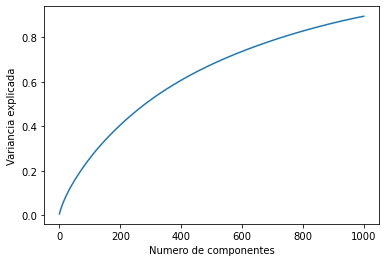

In [24]:
plt.plot(np.cumsum(text_process_pipe['pca'].explained_variance_ratio_))
plt.xlabel('Numero de componentes')
plt.ylabel('Variancia explicada')

# Analise exploratoria de cada classe

Os dados possuem 2 classes são elas:

0 - Tweets sobre desastres que são fake (Não Desastre)

1 - Tweets sobre desastres que são reais (Desastre)

[Text(0, 0, 'Não Desastre'), Text(1, 0, 'Desastre')]

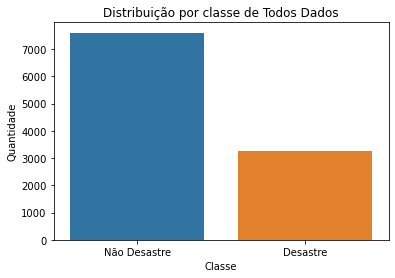

In [25]:
ax = sns.countplot(x='target',data = df)

ax.set_title('Distribuição por classe de Todos Dados')
ax.set_ylabel('Quantidade')
ax.set_xlabel('Classe')
ax.set_xticklabels(["Não Desastre","Desastre"])

Podemos comparar algumas caracteristicas do texto, como tamanho do texto e a quantidade de tokens geradas por cada.

Text(0.5, 1.05, 'Distribuição da quantidade de caracteres do tweet por classe')

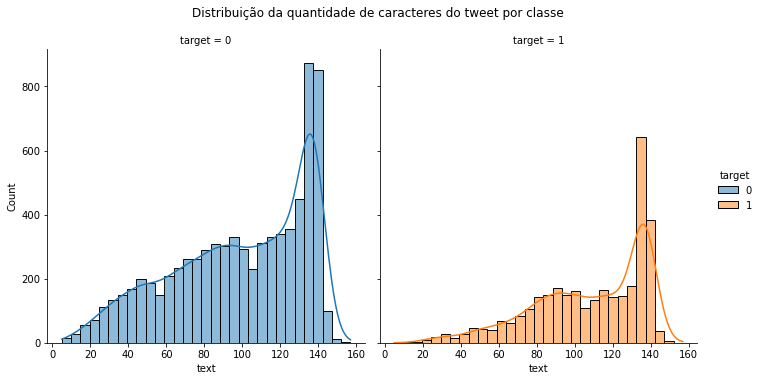

In [26]:
ax = sns.displot(x=df['text'].str.len(),data = df,col='target',hue='target',kde=True)

ax.fig.suptitle('Distribuição da quantidade de caracteres do tweet por classe',y=1.05)

# Classificadores

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

def test_classifier(classifier,params,X_train,y_train,X_test,y_test):
    params = params
    clf = GridSearchCV(classifier, params, n_jobs = -1,cv=5)
    clf.fit(X_train, y_train)
    
    print(clf.best_params_)
    
    y_predicted = clf.predict(X_test)
    
    print(classification_report(y_test, y_predicted))
    ConfusionMatrixDisplay.from_predictions(y_test, y_predicted);
    
    return clf

## Knn

{'n_neighbors': 5}
              precision    recall  f1-score   support

           0       0.76      0.91      0.83      1525
           1       0.60      0.31      0.41       651

    accuracy                           0.73      2176
   macro avg       0.68      0.61      0.62      2176
weighted avg       0.71      0.73      0.70      2176



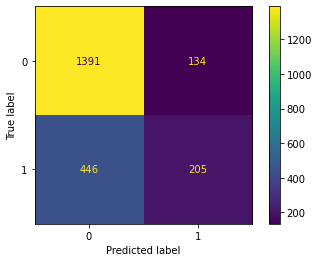

In [42]:
from sklearn.neighbors import KNeighborsClassifier

params = {'n_neighbors': [3,5,7,11,13]}

knn = test_classifier(KNeighborsClassifier(),params,X_train,y_train,X_test,y_test)

## Decision Tree

{'criterion': 'gini', 'max_depth': 4}
              precision    recall  f1-score   support

           0       0.73      0.96      0.83      1525
           1       0.61      0.16      0.25       651

    accuracy                           0.72      2176
   macro avg       0.67      0.56      0.54      2176
weighted avg       0.69      0.72      0.65      2176



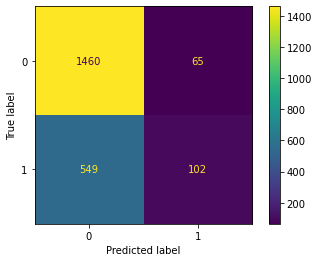

In [44]:
from sklearn.tree import DecisionTreeClassifier

params = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}

dt = test_classifier(DecisionTreeClassifier(),params,X_train,y_train,X_test,y_test)

In [55]:
import graphviz
import pydotplus
from sklearn.tree import DecisionTreeClassifier,export_graphviz

dot_data = export_graphviz(dt.best_estimator_, out_file=None, 
                     filled=True, rounded=True,  
                     special_characters=True)

graph = graphviz.Source(dot_data)  
#graph.render("dt-vis",view = True)
#graph

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

params = {'bootstrap': [True, False],
          'max_depth': [10, 20, 30, None],
          'max_features': ['auto', 'sqrt']}


rf = test_classifier(RandomForestClassifier(),params,X_train,y_train,X_test,y_test)

exception calling callback for <Future at 0x24f2399b670 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "c:\users\vitor\appdata\local\programs\python\python38\lib\site-packages\joblib\externals\loky\_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "c:\users\vitor\appdata\local\programs\python\python38\lib\site-packages\joblib\parallel.py", line 347, in __call__
    self.parallel.dispatch_next()
  File "c:\users\vitor\appdata\local\programs\python\python38\lib\site-packages\joblib\parallel.py", line 780, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "c:\users\vitor\appdata\local\programs\python\python38\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "c:\users\vitor\appdata\local\programs\python\python38\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "c:\users